# WORK IN PROGRESS

## Scanning with an offset beam

In this notebook we want to look at a case where we scan the sky with a very asymmetric beam. Although a Gaussian beam is azimuthally symmetric, a Gaussian beam that has been translated relative to the nominal scanning (centroid) location is not. You can think of this as a case where the beam centroid assumed for map making is far from the actual beam centroid.

In [8]:
import numpy as np
import healpy as hp
from cmb_beams import ScanStrategy
from beamconv import tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def get_cls(fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'):
    cls = np.loadtxt(fname, unpack=True) # Cl in uK^2
    return cls[0], cls[1:]

In [3]:
az_off=4
el_off=4 
polang=36 
lmax=100
fwhm=200
hwp_freq=25. 
pol_only=True

# Load up alm and blm
ell, cls = get_cls()
np.random.seed(30)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK

if pol_only:
    alm = (alm[0]*0., alm[1], alm[2])

# init scan strategy and instrument
mlen = 240 # mission length
ss = ScanStrategy(mlen, # mission duration in sec.
                  sample_rate=1, # sample rate in Hz
                  location='spole') # South pole instrument

# create single detector
ss.create_focal_plane(nrow=1, ncol=1, fov=0, no_pairs=True,
                      polang=polang, lmax=lmax, fwhm=fwhm)

# move detector away from boresight
ss.beams[0][0].az = az_off
ss.beams[0][0].el = el_off

# Start instrument rotated (just to make things complicated)
rot_period =  ss.mlen
ss.set_instr_rot(period=rot_period, start_ang=45)

# Set HWP rotation
ss.set_hwp_mod(mode='stepped', freq=1/20., start_ang=45,
               angles=[34, 12, 67])

# calculate tod in one go (beam is symmetric so mmax=2 suffices)
ss.partition_mission()
ss.scan_instrument_mpi(alm, binning=False, nside_spin=512,
                       max_spin=2)

# Store the tod and pixel indices made with symmetric beam
tod_sym = ss.tod.copy()
pix_sym = ss.pix.copy()

Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-240


In [4]:
# now repeat with asymmetric beam and no detector offset
# set offsets to zero such that tods are generated using
# only the boresight pointing.
ss.beams[0][0].az = 0
ss.beams[0][0].el = 0
ss.beams[0][0].polang = 0

# Convert beam spin modes to E and B modes and rotate them
# create blm again, scan_instrument_mpi detetes blms when done
ss.beams[0][0].gen_gaussian_blm()
blm = ss.beams[0][0].blm
blmI = blm[0].copy()
blmE, blmB = tools.spin2eb(blm[1], blm[2])

# Rotate blm to match centroid.
# Note that rotate_alm uses the ZYZ euler convention.
# Note that we include polang here as first rotation.
q_off = ss.det_offset(az_off, el_off, polang)
ra, dec, pa = ss.quat2radecpa(q_off)

# convert between healpy and math angle conventions
phi = np.radians(ra - 180)
theta = np.radians(90 - dec)
psi = np.radians(-pa)

# rotate blm
hp.rotate_alm([blmI, blmE, blmB], psi, theta, phi, lmax=lmax, mmax=lmax)

# convert beam coeff. back to spin representation.
blmm2, blmp2 = tools.eb2spin(blmE, blmB)
ss.beams[0][0].blm = (blmI, blmm2, blmp2)

ss.reset_instr_rot()
ss.reset_hwp_mod()

ss.scan_instrument_mpi(alm, binning=False, nside_spin=512,
                       max_spin=lmax) # now we use all spin modes

Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-240


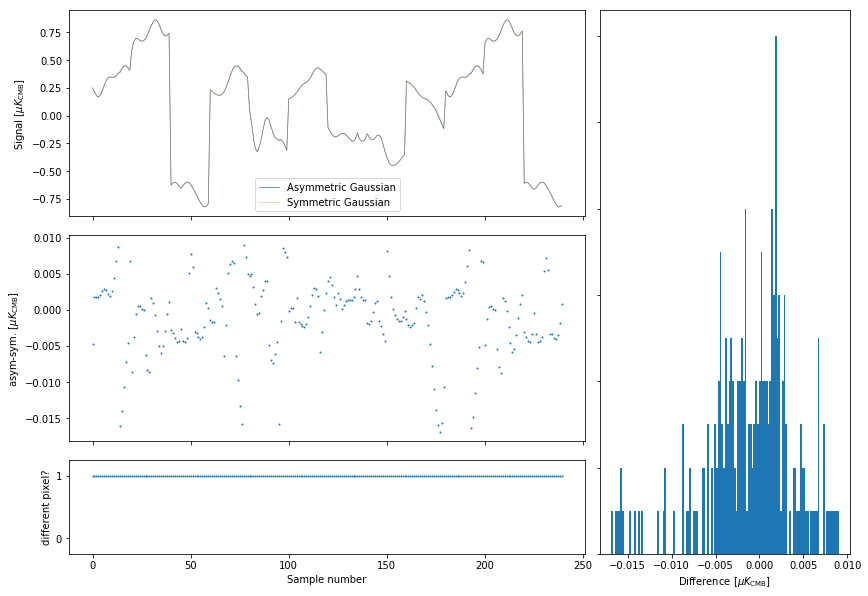

In [11]:
plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(5, 9)
ax1 = plt.subplot(gs[:2, :6])
ax2 = plt.subplot(gs[2:4, :6])
ax3 = plt.subplot(gs[-1, :6])
ax4 = plt.subplot(gs[:, 6:])

samples = np.arange(tod_sym.size)
ax1.plot(samples, ss.tod, label='Asymmetric Gaussian', linewidth=0.7)
ax1.plot(samples, tod_sym, label='Symmetric Gaussian', linewidth=0.7,
         alpha=0.5)
ax1.legend()

ax1.tick_params(labelbottom='off')
sigdiff = ss.tod - tod_sym
ax2.plot(samples, sigdiff,ls='None', marker='.', markersize=2.)
ax2.tick_params(labelbottom='off')
ax3.plot(samples, (pix_sym - ss.pix).astype(bool).astype(int),
         ls='None', marker='.', markersize=2.)
ax1.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax2.set_ylabel(r'asym-sym. [$\mu K_{\mathrm{CMB}}$]')
ax3.set_xlabel('Sample number')
ax3.set_ylabel('different pixel?')
ax3.set_ylim([-0.25,1.25])
ax3.set_yticks([0, 1])

ax4.hist(sigdiff, 128, label='Difference')
ax4.set_xlabel(r'Difference [$\mu K_{\mathrm{CMB}}$]')
ax4.tick_params(labelleft='off')